In [1]:
import numpy as np
import pandas as pd
import tqdm, glob, gc
from numba import jit
from tqdm import tqdm_notebook
from pybel import *
from openbabel import *
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sympy.geometry import Point3D

In [2]:
# initiate the plotly notebook mode
init_notebook_mode(connected=True)


def plot_molecule(molecule_name, structures_df):
    """Creates a 3D plot of the molecule"""
    
    atomic_radii = dict(C=0.77, F=0.71, H=0.38, N=0.75, O=0.73)  
    cpk_colors = dict(C='black', F='green', H='white', N='blue', O='red')

    molecule = structures_df[structures_df.molecule_name == molecule_name]
    coordinates = molecule[['x', 'y', 'z']].values
    x_coordinates = coordinates[:, 0]
    y_coordinates = coordinates[:, 1]
    z_coordinates = coordinates[:, 2]
    elements = molecule.atom.tolist()
    radii = [atomic_radii[element] for element in elements]
    
    def get_bonds():
        """Generates a set of bonds from atomic cartesian coordinates"""
        ids = np.arange(coordinates.shape[0])
        bonds = dict()
        coordinates_compare, radii_compare, ids_compare = coordinates, radii, ids
        
        for _ in range(len(ids)):
            coordinates_compare = np.roll(coordinates_compare, -1, axis=0)
            radii_compare = np.roll(radii_compare, -1, axis=0)
            ids_compare = np.roll(ids_compare, -1, axis=0)
            distances = np.linalg.norm(coordinates - coordinates_compare, axis=1)
            bond_distances = (radii + radii_compare) * 1.3
            mask = np.logical_and(distances > 0.1, distances <  bond_distances)
            distances = distances.round(2)
            new_bonds = {frozenset([i, j]): dist for i, j, dist in zip(ids[mask], ids_compare[mask], distances[mask])}
            bonds.update(new_bonds)
        return bonds            
            
    def atom_trace():
        """Creates an atom trace for the plot"""
        colors = [cpk_colors[element] for element in elements]
        markers = dict(color=colors, line=dict(color='lightgray', width=2), size=7, symbol='circle', opacity=0.8)
        trace = go.Scatter3d(x=x_coordinates, y=y_coordinates, z=z_coordinates, mode='markers', marker=markers,
                             text=elements, name='')
        return trace

    def bond_trace():
        """"Creates a bond trace for the plot"""
        trace = go.Scatter3d(x=[], y=[], z=[], hoverinfo='none', mode='lines',
                             marker=dict(color='grey', size=7, opacity=1))
        for i, j in bonds.keys():
            trace['x'] += (x_coordinates[i], x_coordinates[j], None)
            trace['y'] += (y_coordinates[i], y_coordinates[j], None)
            trace['z'] += (z_coordinates[i], z_coordinates[j], None)
        return trace
    
    bonds = get_bonds()
    
    zipped = zip(range(len(elements)), x_coordinates, y_coordinates, z_coordinates)
    annotations_id = [dict(text=num, x=x, y=y, z=z, showarrow=False, yshift=15, font = dict(color = "blue"))
                   for num, x, y, z in zipped]
    
    annotations_length = []
    for (i, j), dist in bonds.items():
        p_i, p_j = Point3D(coordinates[i]), Point3D(coordinates[j])
        p = p_i.midpoint(p_j)
        annotation = dict(text=dist, x=float(p.x), y=float(p.y), z=float(p.z), showarrow=False, yshift=15)
        annotations_length.append(annotation)   
    
    updatemenus = list([
        dict(buttons=list([
                 dict(label = 'Atom indices',
                      method = 'relayout',
                      args = [{'scene.annotations': annotations_id}]),
                 dict(label = 'Bond lengths',
                      method = 'relayout',
                      args = [{'scene.annotations': annotations_length}]),
                 dict(label = 'Atom indices & Bond lengths',
                      method = 'relayout',
                      args = [{'scene.annotations': annotations_id + annotations_length}]),
                 dict(label = 'Hide all',
                      method = 'relayout',
                      args = [{'scene.annotations': []}])
                 ]),
                 direction='down',
                 xanchor = 'left',
                 yanchor = 'top'
            ),        
    ])
    
    data = [atom_trace(), bond_trace()]
    axis_params = dict(showgrid=False, showbackground=False, showticklabels=False, zeroline=False, titlefont=dict(color='white'))
    layout = dict(scene=dict(xaxis=axis_params, yaxis=axis_params, zaxis=axis_params, annotations=annotations_id), 
                  margin=dict(r=0, l=0, b=0, t=0), showlegend=False, updatemenus=updatemenus)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

# Read necessary files

In [3]:
struct = pd.read_csv('../data/structures.csv')
train = pd.read_csv('../data/train.csv')
tes = pd.read_csv('../data/test.csv')

In [4]:
struct.head(3)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277


In [5]:
train.head(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548


# Pybel MVP

In [6]:
mol_file = '../data/structures/dsgdb9nsd_035567.xyz'

In [7]:
plot_molecule(mol_file.split('/')[-1].split('.')[0], struct)

In [8]:
def gen_lookups(df, gb_col):
    '''
    return a cumsum array starting at 0 and a dict to map gb_col to its positions
    '''
    ss = df.groupby(gb_col).size().cumsum()
    ssx = np.zeros(len(ss)+1).astype(int)
    ssx[1:] = ss.values
    ssdict = {}
    for i, col in enumerate(ss.index):
        ssdict[col] = i
    return ssx, ssdict

In [9]:
# Load data
structures = pd.read_csv('../data/structures.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [10]:
# structures.head(2), train.head(2)
# def reorder_pairs
# train = pd.merge(
#     train, df, how='left'
#     left_on=['molecule_name', f'atom_index_{atom_ix:d}'],
#     right_on=['molecule_name', f'atom_index'],
# )

In [11]:
# Fast lookups
xyz_ssx, xyz_dict = gen_lookups(structures, 'molecule_name')
train_ssx, train_dict = gen_lookups(train, 'molecule_name')
test_ssx, test_dict = gen_lookups(test, 'molecule_name')

TYPE_DICT = {
    '1JHN':0,
    '1JHC':1,
    '2JHH':2,
    '2JHN':3,
    '2JHC':4,
    '3JHH':5,
    '3JHC':6,
    '3JHN':7,
}

# Numpy data
xyz = structures[['x', 'y', 'z']].values.astype(np.float32)
xyz_atom = structures['atom'].map({'H':1, 'C':6, 'N':7, 'O':8, 'F':9}).values.astype(np.uint8)
train_pairs = train[['atom_index_0', 'atom_index_1']].values.astype(np.int8)
train_types = train['type'].map(TYPE_DICT).values.astype(np.uint8)
train_ptypes = np.hstack([train_pairs, train_types[:, None]])
test_pairs = test[['atom_index_0', 'atom_index_1']].values.astype(np.int8)
test_types = test['type'].map(TYPE_DICT).values.astype(np.uint8)
test_ptypes = np.hstack([test_pairs, test_types[:, None]])

mol_names = [g.split('/')[-1].split('.')[0] for g in glob.glob('../data/structures/*.xyz')[:]]

In [21]:
%%time
ring_feature_base_names = [
    'min_ring_size',
    'max_ring_size',
    'delta_ring_size',
    'nrings',
]

# 'dsgdb9nsd_005567'
for mol_name in ['dsgdb9nsd_035567']:
    for mol in readfile('xyz', f'../data/structures/{mol_name}.xyz'):
        mol = mol.OBMol

    # Bond types matrix to allow for custom features for each bond type
    mol_pairs_ix = train_dict[mol_name]
    mol_ptypes = train_ptypes[train_ssx[mol_pairs_ix]:train_ssx[mol_pairs_ix + 1], :]
    
    # Fill orders, angles and torsions matrices
    bonds = []
    for bond in OBMolBondIter(mol):
        beg_ix = bond.GetBeginAtomIdx()
        end_ix = bond.GetEndAtomIdx()
        order = bond.GetBondOrder()
        bonds.append([beg_ix - 1, end_ix - 1, order])
    bond_mat = np.vstack(bonds)
    
    angles = []
    for angle in OBMolAngleIter(mol):
        # WARNING : angles come with center atom first, hence the 1 0 2 order to compute the correct angle
        angle_in_degrees = mol.GetAngle(mol.GetAtom(angle[1]+1), mol.GetAtom(angle[0]+1), mol.GetAtom(angle[2]+1))
        angles.append([angle[1], angle[0], angle[2], angle_in_degrees])
    angle_mat = np.vstack(angles)

    torsions = []
    for torsion in OBMolTorsionIter(mol):
        torsion_in_degrees = mol.GetTorsion(torsion[0]+1, torsion[1]+1, torsion[2]+1, torsion[3]+1)
        torsions.append([torsion[0], torsion[1], torsion[2], torsion[3], torsion_in_degrees])
    torsion_mat = np.vstack(torsions)
    
    # Ring info
    
    rmat = None
    ring_infos = []
    for ring in mol.GetSSSR():
        RSIZE = ring.Size()
        rixs = np.array(ring._path)-1
        rsize = np.ones(RSIZE)*RSIZE
        ring_infos.append(np.vstack([rixs, rsize]))
    if ring_infos:
        rmat = np.hstack(ring_infos).T
    
    # Feat engineering

    NPAIRS = mol_ptypes.shape[0]
    feature_chunk = np.empty(shape=(NPAIRS, len(ring_feature_base_names)), dtype=np.float32)
    feature_chunk.fill(np.nan)
    mn_mat = numba_fill_paths(abt=mol_ptypes, angle_mat=angle_mat, torsion_mat=torsion_mat)
mn_mat
# a=pd.DataFrame(data=feature_chunk, columns=feature_names).astype(feature_names)
# pd.concat([train.loc[train.molecule_name == 'dsgdb9nsd_005567', :].reset_index(), a.reset_index()], axis=1).head(2)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'numba_find_line': cannot determine Numba type of <class 'numba.ir.UndefinedType'>

File "<ipython-input-14-dcb6e6352e0e>", line 18:
def numba_fill_paths(abt, angle_mat, torsion_mat):
    <source elided>
            sub_amat = np.vstack((angle_mat[:, 0], angle_mat[:, 2])).T
            angle_ixs = numba_find_line(pair, sub_amat)
            ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [14]:
@jit(nopython=True)
def numba_fill_paths(abt, angle_mat, torsion_mat):
    '''
    given abt, with pair ixs on first 2 cols and encoded bond type on 3rd col
    returns a 2col matrix with first col filled with middle ix for 2J or 1st and 2nd cols
    filled for 3J
    '''
    
    NA = -1
    mn = np.ones((abt.shape[0], 2)) * NA
    for i, line in enumerate(abt):
        pair = line[:2]
        t = line[2] 
        if t==0 or t==1:
            continue
        elif t==2 or t==3 or t==4:
            sub_amat = np.vstack((angle_mat[:, 0], angle_mat[:, 2])).T
            angle_ixs = numba_find_line(pair, sub_amat)
            m_ix = angle_mat[angle_ixs[0], 1]
            mn[i, 0] = m_ix      
        else:
            sub_tmat = np.vstack((torsion_mat[:, 0], torsion_mat[:, 3])).T
            torsion_ixs = numba_find_line(pair, sub_tmat)
            m_ix = torsion_mat[torsion_ixs[0], 1]
            n_ix = torsion_mat[torsion_ixs[0], 2]
            mn[i, 0] = m_ix
            mn[i, 1] = n_ix
    return mn

ixs = np.array([7,8,3,3])
numba_ring_mat_feats(rmat=rmat, ixs=ixs)

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 4, 10,  6,  2],
       [ 4, 10,  6,  2]], dtype=uint8)

In [32]:
for mol_name in tqdm_notebook(mol_names):
    mol_ix = xyz_dict[mol_name]
    mol_xyz = xyz[xyz_ssx[mol_ix]:xyz_ssx[mol_ix + 1], :]
    mol_atom = xyz_atom[xyz_ssx[mol_ix]:xyz_ssx[mol_ix + 1]]
    
    mol = OBMol()
    for i in range(mol_xyz.shape[0]):
        atm = OBAtom()
        atm.SetAtomicNum(int(mol_atom[i]))
        atm.SetVector(float(mol_xyz[i, 0]), float(mol_xyz[i, 1]), float(mol_xyz[i, 2]))
        mol.AddAtom(atm)
    mol = Molecule(mol)
    mol.OBMol.ConnectTheDots()
    mol.OBMol.PerceiveBondOrders()
    mol.OBMol.FindAngles()
    mol.OBMol.FindTorsions()
    for atm in mol:
            ix = atm.idx - 1

KeyboardInterrupt: 

In [13]:
@jit(nopython=True)
def numba_ring_mat_feats(rmat, ixs):
    '''
    Given rmat with 2 columns, where column 1 is atom_ix and column 2 is the size of the ring where it was found
    compute a number of ring features for atoms with ixs specified in 'ixs'
    
    One atom ix can appear more than once on rmat's column 1
    '''
    
    NFEATS = 4
    MAX_NUM_RINGS = 8
    NRMAT = rmat.shape[0]
    NIXS = ixs.shape[0]
    
    fmat = np.empty(shape=(NIXS, NFEATS), dtype=np.uint8)
    for i in range(NIXS):
        ix = ixs[i]
        rsf = np.zeros(MAX_NUM_RINGS, dtype=np.uint8)
        iii = 0
        for j in range(NRMAT):
            if rmat[j, 0] == ix:
                rsf[iii] = rmat[j, 1]
                iii += 1

        # default feat vals
        min_r_size = 0
        max_r_size = 0
        delta_r_size = 0
        nrings = iii

        # if rings found
        if nrings > 0:
            rsf = rsf[rsf > 0]
            min_r_size = np.min(rsf)
            max_r_size = np.max(rsf)
            delta_r_size = max_r_size - min_r_size

        fmat[i, 0] = min_r_size
        fmat[i, 1] = max_r_size
        fmat[i, 2] = delta_r_size
        fmat[i, 3] = nrings
    
    return fmat

rmat = np.array([
    [3,4],
    [2,4],
    [3,10],
    [11,4]
])

In [16]:
for mol_name in tqdm_notebook(mol_names):
    for mol in readfile('xyz', f'../data/structures/{mol_name}.xyz'):
        for atm in mol:
            ix = atm.idx - 1
#             bonds = []
#             for bond in OBAtomBondIter(atm.OBAtom):
#                 beg_ix = bond.GetBeginAtomIdx() - 1
#                 end_ix = bond.GetEndAtomIdx() - 1
#                 bond_order = bond.GetBondOrder()
#                 bonds.append(f'{bond_order:d}-bond | {beg_ix:d}-{end_ix:d}')

    
    # Create molecule
    
#     mol_ix = xyz_dict[mol_name]
#     mol_xyz = xyz[xyz_ssx[mol_ix]:xyz_ssx[mol_ix + 1], :]
#     mol_atom = xyz_atom[xyz_ssx[mol_ix]:xyz_ssx[mol_ix + 1]]
#     mol_pairs_ix = train_dict[mol_name]
#     mol_pairs = train_pairs[train_ssx[mol_pairs_ix]:train_ssx[mol_pairs_ix + 1], :]
    
#     mol = OBMol()
#     for i in range(mol_xyz.shape[0]):
#         atm = OBAtom()
#         atm.SetAtomicNum(int(mol_atom[i]))
#         atm.SetVector(float(mol_xyz[i, 0]), float(mol_xyz[i, 1]), float(mol_xyz[i, 2]))
#         mol.AddAtom(atm)
        
#     mol.ConnectTheDots()
#     mol.PerceiveBondOrders()
#     mol.FindAngles()
#     mol.FindTorsions()

In [20]:
def find_line(line, arr, accept_reverse=True):
    l = list(np.argwhere(np.equal(arr,line).all(axis=1))[:,0])
    if accept_reverse:
        l.extend(np.argwhere(np.equal(arr,line[::-1]).all(axis=1))[:,0])
    return l



In [95]:
%%timeit
a = np.array([[17,2],[10,20],[1,72]])
find_line([10,20], a)

35.8 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [119]:
%%timeit
a = np.array([[17,2],[10,20],[1,72]])
numba_find_line(np.array([10,20]), a)

4.22 µs ± 54.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [32]:
train = pd.read_csv('../data/train.csv')
f = pd.read_hdf('../features/ring_feats_train.h5')
j = pd.concat([train.reset_index(drop=True), f.reset_index(drop=True)], axis=1)
j.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,x_min_ring_size,x_max_ring_size,x_delta_ring_size,x_nrings,y_min_ring_size,y_max_ring_size,y_delta_ring_size,y_nrings,z_min_ring_size,z_max_ring_size,z_delta_ring_size,z_nrings
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,3.0,3.0,0.0,1.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0,3.0,3.0,0.0,1.0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0,3.0,3.0,0.0,1.0


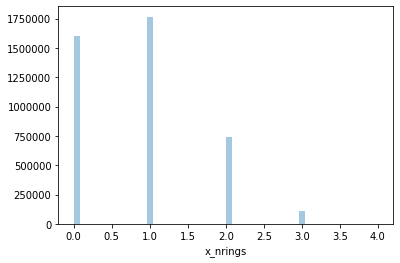

In [41]:
import seaborn as sns
v = j['x_nrings']
v = v[~np.isnan(v)]
sns.distplot(v, kde=False)

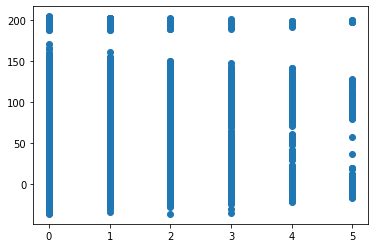

In [48]:
import matplotlib.pyplot as plt
v = j['x_delta_ring_size']
v2 = v[~np.isnan(v)]
u = j['scalar_coupling_constant']
u = u[~np.isnan(v)]
plt.scatter(v2, u)

In [52]:
f = pd.read_hdf('../features/gps_base_train.h5')
f.head(2)

,d0_0,d0_1,d0_2,d0_3,d1_0,d1_1,d1_2,d1_3,d2_0,d2_1,...,d12_2,d12_3,d13_0,d13_1,d13_2,d13_3,d14_0,d14_1,d14_2,d14_3
0,0.0,1.091953,1.783120,1.783147,1.091953,0.0,1.091952,1.091946,1.783120,1.091952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.783120,1.091953,1.783157,1.783120,0.0,1.091952,1.783148,1.091953,1.091952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


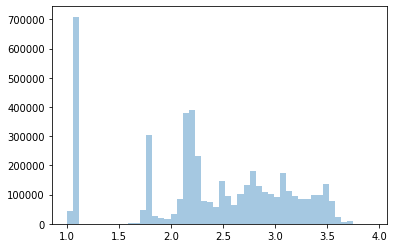

In [53]:
sns.distplot(f['d0_1'].values, kde=False)

In [54]:
ss = pd.read_hdf('../features/cyl_feats_train.h5')
ss.head()

,cyl_r_0.10,cyl_r_0.20,cyl_r_0.50,cyl_r_1.00,cyl_r_1.50,cyl_r_2.00,cyl_r_3.00
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,3.0,3.0
2,0.0,0.0,0.0,1.0,1.0,3.0,3.0
3,0.0,0.0,0.0,1.0,1.0,3.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
vs = ss.values
np.sum(vs, axis=0)

array([   33914.,    54473.,   616505.,  5094603.,  8644197., 14532945.,
       27247196.], dtype=float32)

In [ ]:
for c in ss.columns:
    print(f'\n')